In [1]:
import segmentation_models_pytorch as smp
import copy
import torch
import os 
import gc

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchmetrics import JaccardIndex
from torchinfo import summary

d:\Program Files (x86)\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Устройство для обучения
device

device(type='cuda')

## Настройка параметров

In [3]:
pretrained = False  # Пропустить обучение модели

# Директории с датасетами
train_path        = './fixed_train/'
train_labels_path = './fixed_train_labels/'

val_path        = './val'
val_labels_path = './val_labels/'

test_path        = './test'
test_labels_path = './test_labels./'

# Настройки преобразований изображений
size = 224                    # До какого размера изменить входное изображение
mean = [0.485, 0.456, 0.406]  # Среднее значение для нормирования каналов
std  = [0.229, 0.224, 0.225]  # Стандратное отклонение для нормирования каналов

num_epochs = 30
batch_size = 1

# Параметры оптимизатора
momentum = 0.9
weight_decay = 5e-4
lr = 5e-3

# Параметры планировщика
base_lr = lr
max_lr = 0.1
step_size_up = 5
mode = "triangular2"

In [4]:
# Преобразование изображений
transform = transforms.Compose([
    #transforms.ColorJitter(),
    #transforms.RandomHorizontalFlip(p = 0.5),
    transforms.CenterCrop(1472),
    transforms.ToTensor()])
    #transforms.Normalize(mean = mean, std = std)]) # Нормирование каждого канала изображения

## Подготовка датасетов

In [5]:
class road_Dataset(Dataset):

    def __init__(self, images_dir, masks_dir, transforms = None):

        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.images     = os.listdir(images_dir)
        self.masks      = os.listdir(masks_dir)
        self.transforms = transforms

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.images_dir, self.images[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.masks_dir, self.masks[idx])).convert('1')

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        # Применение one-hot encoding для маски
        one_hot_mask = np.zeros((2, mask.shape[1], mask.shape[2]))
        one_hot_mask[0] = np.where(mask == 0, 1, 0)
        one_hot_mask[1] = mask

        return image, one_hot_mask
    
    def __len__(self):
        return len(self.images)

In [6]:
# Создание датасетов
train_dataset = road_Dataset(train_path, train_labels_path, transforms = transform)
val_dataset   = road_Dataset(val_path, val_labels_path, transforms = transform)
test_dataset  = road_Dataset(test_path, test_labels_path, transforms = transform)

n_train = len(train_dataset) # Количество изображений в тренировочном датасете
n_val   = len(val_dataset)   # Количество изображений в валидационном датасете
n_test  = len(test_dataset)  # Количество изображений в тестовом датасете

## Создание загрузчиков 

In [7]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)

## Вывод изображений с масками

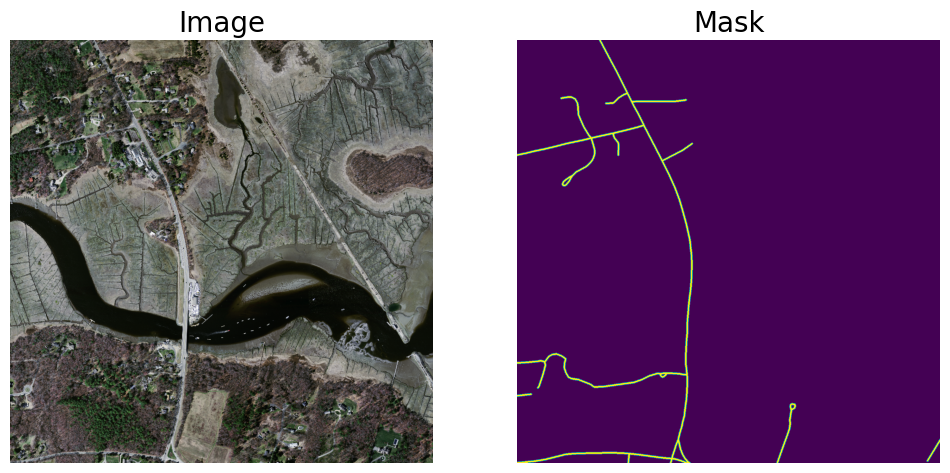

In [8]:
# Вывод заданного количества изображений
def imshow(images, masks, cnt):

    # Подготовка холста для изображений
    fig, axs = plt.subplots(cnt, 2)
    axs = axs.flatten()

    fig.set_figwidth(12)
    fig.set_figheight(cnt * 6)

    for i, (image, mask) in enumerate(zip(images[:cnt], masks[:cnt])):
        
        # Приведение массивов к формату (H, W, Ch)
        npimg = image.numpy()
        npmask = mask[1].numpy()

        npimg = np.transpose(npimg, (1, 2, 0)).squeeze()

        # Вывод изображения
        axs[i * 2].imshow(npimg)
        axs[i * 2 + 1].imshow(npmask)

        axs[i * 2].set_axis_off()
        axs[i * 2 + 1].set_axis_off()

        if i == 0:
            axs[0].set_title('Image', fontsize = 20)
            axs[1].set_title('Mask', fontsize = 20)
 
    plt.show()
   
# Получить случайные тренировочные изображения
dataiter = iter(train_loader)
images, masks = next(dataiter)

imshow(images, masks, 1)

## Создание модели

In [9]:
model = smp.Unet(encoder_name = 'resnet50', encoder_weights = 'imagenet', in_channels = 3, classes = 2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = weight_decay)
schedule = CyclicLR(optimizer, base_lr = base_lr, max_lr = max_lr, step_size_up = step_size_up, mode = mode, cycle_momentum = False)

# Загрузить сохраненные веса в модель
if pretrained:
    model.load_state_dict(torch.load('./weights.h5'))

## Обучение модели

In [10]:
if not pretrained:

    # Значения функции потерь в течение обучения
    train_losses = np.zeros(num_epochs) 
    val_losses = np.zeros(num_epochs)

    # Значения IOU в течение обучения
    train_IOUs = np.zeros(num_epochs) 
    val_IOUs = np.zeros(num_epochs)

    lrs = []
    
    for epoch in (pbar := tqdm(range(num_epochs))):
        
        best_weights = copy.deepcopy(model.state_dict())
        best_IOU = 0

        train_IOU = JaccardIndex(task = 'binary', average = 'macro').to(device)
        val_IOU = JaccardIndex(task = 'binary', average = 'macro').to(device)

        model.train()

        for images, masks in train_loader:  

            # Отправить тензоры на выбранное устройство для обучения
            images = images.to(device)
            masks = masks.to(device)
            
            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, masks)           
            train_losses[epoch] += loss

            train_IOU.update(outputs, masks)

            # Обратный проход и оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lrs.append(optimizer.param_groups[0]["lr"])
            
            # Очистить память
            del images, masks, outputs
            torch.cuda.empty_cache()
            gc.collect()

        train_IOUs[epoch] = 100 * train_IOU.compute()
        train_losses[epoch] /= len(train_loader)
        
        schedule.step(train_losses[epoch])
       
        # Валидация
        with torch.no_grad():

            model.eval()

            for images, masks in val_loader:

                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_losses[epoch] += loss

                val_IOU.update(outputs, masks)
                
                del images, masks, outputs
                torch.cuda.empty_cache()
                gc.collect()

            val_losses[epoch] /= len(val_loader)
            val_IOUs[epoch] = 100 * val_IOU.compute()

            # Сохранение весов, если результат на текущей эпохе лучше
            if best_IOU < val_IOUs[epoch]:
                best_IOU = val_IOUs[epoch]
                best_weights = copy.deepcopy(model.state_dict())

        torch.cuda.empty_cache()
        gc.collect()

        pbar.set_description(f'Avg. train/valid loss: [{train_losses[epoch].item():.2f}/{val_losses[epoch].item():.2f}], train/valid IOU: [{train_IOUs[epoch]:.2f}%/{val_IOUs[epoch]:.2f}%]')

    # Загрузка и сохранение лучших весов
    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), './weights.h5')


  0%|          | 0/30 [00:00<?, ?it/s]d:\Program Files (x86)\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Avg. train/valid loss: [0.04/0.13], train/valid IOU: [96.69%/93.55%]: 100%|██████████| 30/30 [3:55:07<00:00, 470.24s/it]  


## Графики

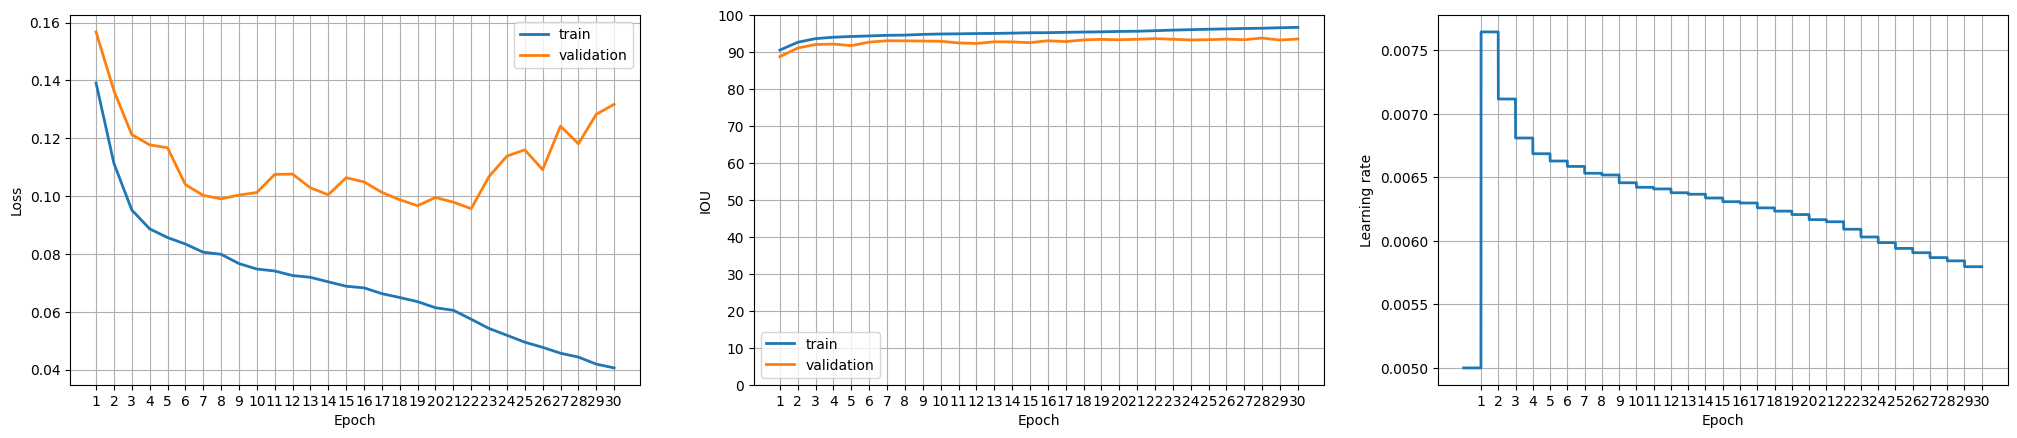

In [11]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(25) 

axs[0].plot(range(1, num_epochs + 1), train_losses, linewidth = 2, label = 'train')
axs[0].plot(range(1, num_epochs + 1), val_losses, linewidth = 2, label = 'validation')
axs[0].set_xticks(range(1, num_epochs + 1))
axs[0].set_xlabel('Epoch') 
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(range(1, num_epochs + 1), train_IOUs, linewidth = 2, label = 'train')
axs[1].plot(range(1, num_epochs + 1), val_IOUs, linewidth = 2, label = 'validation')
axs[1].set_xticks(range(1, num_epochs + 1))
axs[1].set_yticks(range(0, 101, 10))
axs[1].set_xlabel('Epoch') 
axs[1].set_ylabel('IOU')
axs[1].legend()
axs[1].grid()

axs[2].plot(np.linspace(0, num_epochs, len(lrs)), lrs, linewidth = 2)
axs[2].set_xticks(range(1, num_epochs + 1))
axs[2].set_xlabel('Epoch') 
axs[2].set_ylabel('Learning rate')
axs[2].grid()

plt.show()

## Тестирование модели

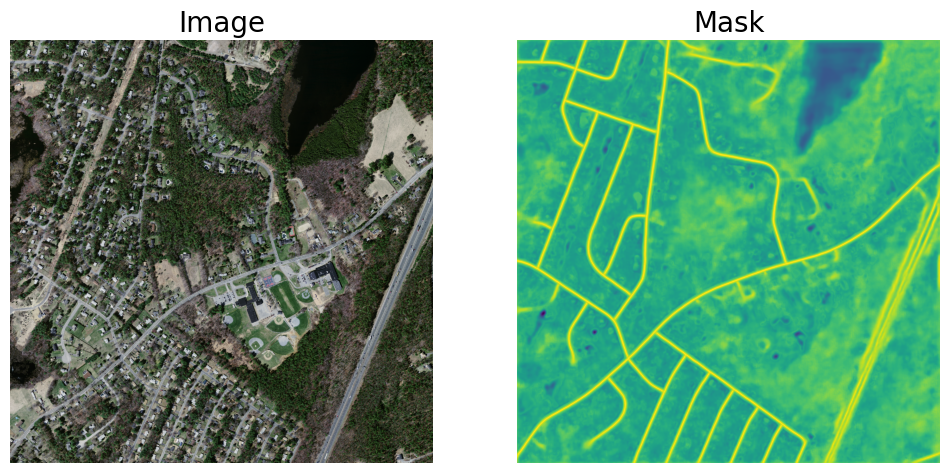

IOU-score of the network on the 49 testing images: 95.8304 %


In [15]:
IOU = JaccardIndex(task = 'binary', average = 'macro').to(device)
model.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        IOU.update(outputs, masks)
        
        # Отобразить изображения с предсказанными названиями
        if not i:
            imshow(images.cpu(), outputs.cpu(), 1)

        del images, masks, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print('IOU-score of the network on the {} testing images: {:.4f} %'.format(n_test, 100 * IOU.compute()))